<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/advanced_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here, I attempt to extend the foundations of pruning with techniques that achieve better trade-offs between accuracy and sparsity. I implement movement pruning, which prunes weights that are moving toward zero during training rather than those that are currently small. We explore learned sparsity, where the pruning mask itself becomes a differentiable, trainable parameter. We then implement N:M structured sparsity—NVIDIA's innovation that guarantees exactly N zeros in every M consecutive weights, enabling 2x speedup on Ampere GPUs. Our experimental framework compares these methods against magnitude pruning baselines, demonstrating when each technique excels. The analysis connects to practical deployment: how do you achieve 90%+ sparsity while maintaining accuracy? When does structured sparsity beat unstructured? How do these methods combine with quantisation and distillation?

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Tuple, Callable
from dataclasses import dataclass
from copy import deepcopy
from collections import OrderedDict
from tqdm import tqdm
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Base model and utilities from Day 9
class PrunableMLP(nn.Module):
    """
    MLP with explicit mask support for pruning experiments.
    """

    def __init__(self, hidden_dims: List[int] = [512, 256, 128]):
        super().__init__()

        self.layers = nn.ModuleList()
        self.masks = nn.ParameterDict()  # Store masks as buffers

        prev_dim = 784
        for i, dim in enumerate(hidden_dims):
            layer = nn.Linear(prev_dim, dim)
            self.layers.append(layer)
            # Initialize mask as all ones (nothing pruned)
            self.register_buffer(f'mask_{i}', torch.ones_like(layer.weight))
            prev_dim = dim

        self.output = nn.Linear(prev_dim, 10)
        self.register_buffer('mask_out', torch.ones_like(self.output.weight))

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def get_mask(self, layer_idx: int) -> torch.Tensor:
        """Get mask for a layer."""
        if layer_idx < len(self.layers):
            return getattr(self, f'mask_{layer_idx}')
        else:
            return self.mask_out

    def set_mask(self, layer_idx: int, mask: torch.Tensor):
        """Set mask for a layer."""
        if layer_idx < len(self.layers):
            setattr(self, f'mask_{layer_idx}', mask)
        else:
            self.mask_out = mask

    def apply_masks(self):
        """Apply masks to weights (zero out pruned weights)."""
        for i, layer in enumerate(self.layers):
            mask = self.get_mask(i)
            layer.weight.data *= mask
        self.output.weight.data *= self.mask_out

    def forward(self, x):
        x = x.view(x.size(0), -1)

        for i, layer in enumerate(self.layers):
            # Apply mask during forward (for gradient flow)
            mask = self.get_mask(i)
            x = F.linear(x, layer.weight * mask, layer.bias)
            x = F.relu(x)

        x = F.linear(x, self.output.weight * self.mask_out, self.output.bias)
        return x

    def get_sparsity(self) -> Dict[str, float]:
        """Get sparsity statistics."""
        stats = {}
        total_params = 0
        total_zeros = 0

        for i, layer in enumerate(self.layers):
            mask = self.get_mask(i)
            zeros = (mask == 0).sum().item()
            total = mask.numel()
            stats[f'layer_{i}'] = zeros / total
            total_zeros += zeros
            total_params += total

        # Output layer
        zeros = (self.mask_out == 0).sum().item()
        total = self.mask_out.numel()
        stats['output'] = zeros / total
        total_zeros += zeros
        total_params += total

        stats['overall'] = total_zeros / total_params
        return stats

In [18]:
# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 60000, Test: 10000


In [19]:
# Training utilities

def train_epoch(model, train_loader, optimizer, apply_mask_fn=None):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        # Apply mask after optimizer step if provided
        if apply_mask_fn is not None:
            apply_mask_fn()

        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += data.size(0)

    return total_loss / total, correct / total


def evaluate(model, test_loader):
    """Evaluate accuracy."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

    return correct / total


def train_model(model, train_loader, epochs=5, lr=0.001, apply_mask_fn=None):
    """Train model for multiple epochs."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, apply_mask_fn)
        test_acc = evaluate(model, test_loader)
        print(f"Epoch {epoch+1}: Train Acc={100*train_acc:.2f}%, Test Acc={100*test_acc:.2f}%")

    return model

Movement Pruning

Movement pruning prunes weights based on their trajectory during training, not their current magnitude.

Key insight: A small weight that's growing is more important than a large weight that's shrinking.

Movement score: Instead of |w|, I use |w * grad(w)| or track w(t) - w(0).

In [20]:
class MovementPruner:


    def __init__(self, model: PrunableMLP, target_sparsity: float = 0.9):
        """
        Args:
            model: Model to prune
            target_sparsity: Target sparsity level
        """
        self.model = model
        self.target_sparsity = target_sparsity

        # Store initial weights for movement calculation
        self.initial_weights: Dict[str, torch.Tensor] = {}
        self._store_initial_weights()

        # Movement scores (accumulated)
        self.movement_scores: Dict[str, torch.Tensor] = {}
        self._init_movement_scores()

    def _store_initial_weights(self):
        """Store initial weights for movement calculation."""
        for i, layer in enumerate(self.model.layers):
            self.initial_weights[f'layer_{i}'] = layer.weight.data.clone()
        self.initial_weights['output'] = self.model.output.weight.data.clone()

    def _init_movement_scores(self):
        """Initialize movement scores to zero."""
        for i, layer in enumerate(self.model.layers):
            self.movement_scores[f'layer_{i}'] = torch.zeros_like(layer.weight.data)
        self.movement_scores['output'] = torch.zeros_like(self.model.output.weight.data)

    def update_movement_scores(self, use_gradient: bool = True):
        """
        Update movement scores based on current weights.

        Args:
            use_gradient: If True, use w * grad as instantaneous movement.
                         If False, use w * (w - w_init) as total movement.
        """
        for i, layer in enumerate(self.model.layers):
            key = f'layer_{i}'
            w = layer.weight.data

            if use_gradient and layer.weight.grad is not None:
                # Instantaneous movement: w * grad
                # Positive = moving away from zero, Negative = moving toward zero
                movement = w * layer.weight.grad
            else:
                # Total movement from initialization
                movement = w * (w - self.initial_weights[key])

            # Accumulate (exponential moving average)
            self.movement_scores[key] = 0.9 * self.movement_scores[key] + 0.1 * movement

        # Output layer
        w = self.model.output.weight.data
        if use_gradient and self.model.output.weight.grad is not None:
            movement = w * self.model.output.weight.grad
        else:
            movement = w * (w - self.initial_weights['output'])
        self.movement_scores['output'] = 0.9 * self.movement_scores['output'] + 0.1 * movement

    def compute_masks(self, global_pruning: bool = True) -> Dict[str, torch.Tensor]:
        """
        Compute pruning masks based on movement scores.

        Prune weights with NEGATIVE movement (moving toward zero).
        Keep weights with POSITIVE movement (moving away from zero).

        Args:
            global_pruning: If True, use global threshold across all layers

        Returns:
            Dict of masks for each layer
        """
        masks = {}

        if global_pruning:
            # Collect all scores
            all_scores = torch.cat([
                self.movement_scores[key].flatten()
                for key in self.movement_scores
            ])

            # Find threshold (prune weights with lowest scores)
            k = int(len(all_scores) * self.target_sparsity)
            threshold = torch.kthvalue(all_scores, k)[0]

            # Create masks
            for key in self.movement_scores:
                masks[key] = (self.movement_scores[key] > threshold).float()
        else:
            # Per-layer pruning
            for key, scores in self.movement_scores.items():
                flat_scores = scores.flatten()
                k = int(len(flat_scores) * self.target_sparsity)
                threshold = torch.kthvalue(flat_scores, k)[0]
                masks[key] = (scores > threshold).float()

        return masks

    def apply_masks(self, masks: Dict[str, torch.Tensor]):
        """Apply masks to model."""
        for i in range(len(self.model.layers)):
            self.model.set_mask(i, masks[f'layer_{i}'])
        self.model.set_mask(len(self.model.layers), masks['output'])
        self.model.apply_masks()

In [21]:
class SoftMovementPruning:
    """
    Soft Movement Pruning with differentiable masks.

    Instead of hard binary masks, use soft masks that are trained
    alongside the weights. The mask values are driven toward 0 or 1
    during training.

    Uses the straight-through estimator for gradients through the
    thresholding operation.
    """

    def __init__(
        self,
        model: PrunableMLP,
        initial_sparsity: float = 0.0,
        final_sparsity: float = 0.9,
        warmup_steps: int = 100
    ):
        self.model = model
        self.initial_sparsity = initial_sparsity
        self.final_sparsity = final_sparsity
        self.warmup_steps = warmup_steps
        self.current_step = 0

        # Initialize soft mask scores (sigmoid applied to get [0,1])
        self.mask_scores: Dict[str, nn.Parameter] = {}
        self._init_mask_scores()

    def _init_mask_scores(self):
        """Initialize mask scores (before sigmoid)."""
        for i, layer in enumerate(self.model.layers):
            # Initialize to positive values so sigmoid starts near 1
            score = nn.Parameter(torch.ones_like(layer.weight) * 5.0)
            self.mask_scores[f'layer_{i}'] = score

        score = nn.Parameter(torch.ones_like(self.model.output.weight) * 5.0)
        self.mask_scores['output'] = score

    def get_mask_parameters(self) -> List[nn.Parameter]:
        """Get mask parameters for optimizer."""
        return list(self.mask_scores.values())

    def get_current_sparsity_target(self) -> float:
        """Get current sparsity target based on schedule."""
        if self.current_step >= self.warmup_steps:
            return self.final_sparsity

        # Linear warmup
        progress = self.current_step / self.warmup_steps
        return self.initial_sparsity + progress * (self.final_sparsity - self.initial_sparsity)

    def compute_soft_masks(self) -> Dict[str, torch.Tensor]:
        """
        Compute soft masks using sigmoid.

        Returns masks in [0, 1] range.
        """
        return {key: torch.sigmoid(score) for key, score in self.mask_scores.items()}

    def compute_hard_masks(self) -> Dict[str, torch.Tensor]:
        """
        Compute hard binary masks based on current sparsity target.

        Uses top-k selection to get exactly the target sparsity.
        """
        target = self.get_current_sparsity_target()
        soft_masks = self.compute_soft_masks()

        # Global threshold
        all_scores = torch.cat([m.flatten() for m in soft_masks.values()])
        k = int(len(all_scores) * target)
        k = max(1, min(k, len(all_scores) - 1))
        threshold = torch.kthvalue(all_scores, k)[0]

        return {key: (mask > threshold).float() for key, mask in soft_masks.items()}

    def regularization_loss(self, lambda_sparse: float = 1e-3) -> torch.Tensor:
        """
        Compute sparsity regularization loss.

        Encourages mask scores to be sparse (close to 0).
        """
        soft_masks = self.compute_soft_masks()
        reg = sum(mask.sum() for mask in soft_masks.values())
        return lambda_sparse * reg

    def step(self):
        """Advance training step."""
        self.current_step += 1

Learned Sparsity

Instead of using a fixed criterion (magnitude, movement), make the mask itself learnable. The network learns which weights are important.

In [22]:
class STEFunction(torch.autograd.Function):
    """
    Straight-Through Estimator for binary mask.

    Forward: Hard threshold (0 or 1)
    Backward: Pass gradient through as if identity
    """

    @staticmethod
    def forward(ctx, input, threshold):
        return (input > threshold).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None


def ste_threshold(x, threshold):
    """Apply threshold with straight-through gradient."""
    return STEFunction.apply(x, threshold)

In [23]:
class LearnedSparsityLayer(nn.Module):
    """
    Linear layer with learnable sparsity mask.

    The mask is parameterized and trained alongside weights.
    During forward: mask is binarized with STE
    During backward: gradients flow to mask parameters
    """

    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features

        # Regular weight and bias
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)

        # Learnable mask scores (before sigmoid)
        # Initialize positive so mask starts near 1
        self.mask_scores = nn.Parameter(torch.ones(out_features, in_features) * 3.0)

        self._init_weights()

    def _init_weights(self):
        nn.init.kaiming_normal_(self.weight, nonlinearity='relu')
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def get_mask(self, threshold: float = 0.5) -> torch.Tensor:
        """
        Get binary mask using sigmoid + threshold.

        Uses STE for gradient flow.
        """
        soft_mask = torch.sigmoid(self.mask_scores)
        return ste_threshold(soft_mask, threshold)

    def forward(self, x: torch.Tensor, threshold: float = 0.5) -> torch.Tensor:
        mask = self.get_mask(threshold)
        masked_weight = self.weight * mask
        return F.linear(x, masked_weight, self.bias)

    @property
    def sparsity(self) -> float:
        """Current sparsity (fraction of zeros in mask)."""
        with torch.no_grad():
            mask = self.get_mask()
            return 1.0 - mask.mean().item()


class LearnedSparsityMLP(nn.Module):
    """
    MLP with learned sparsity masks.
    """

    def __init__(self, hidden_dims: List[int] = [512, 256, 128]):
        super().__init__()

        self.layers = nn.ModuleList()
        prev_dim = 784

        for dim in hidden_dims:
            self.layers.append(LearnedSparsityLayer(prev_dim, dim))
            prev_dim = dim

        self.output = LearnedSparsityLayer(prev_dim, 10)

    def forward(self, x, threshold: float = 0.5):
        x = x.view(x.size(0), -1)

        for layer in self.layers:
            x = F.relu(layer(x, threshold))

        return self.output(x, threshold)

    def sparsity_loss(self, target_sparsity: float = 0.9, lambda_sparse: float = 0.1) -> torch.Tensor:
        """
        Compute loss to encourage target sparsity.

        Penalizes deviation from target sparsity.
        """
        total_mask = 0
        total_params = 0

        for layer in self.layers:
            soft_mask = torch.sigmoid(layer.mask_scores)
            total_mask += soft_mask.sum()
            total_params += soft_mask.numel()

        soft_mask = torch.sigmoid(self.output.mask_scores)
        total_mask += soft_mask.sum()
        total_params += soft_mask.numel()

        # Current density (1 - sparsity)
        current_density = total_mask / total_params
        target_density = 1 - target_sparsity

        # L2 penalty on deviation
        return lambda_sparse * (current_density - target_density) ** 2

    def get_sparsity(self) -> Dict[str, float]:
        """Get sparsity for each layer."""
        stats = {}
        total_zeros = 0
        total_params = 0

        for i, layer in enumerate(self.layers):
            stats[f'layer_{i}'] = layer.sparsity
            mask = layer.get_mask()
            total_zeros += (mask == 0).sum().item()
            total_params += mask.numel()

        stats['output'] = self.output.sparsity
        mask = self.output.get_mask()
        total_zeros += (mask == 0).sum().item()
        total_params += mask.numel()

        stats['overall'] = total_zeros / total_params
        return stats

 N:M Structured Sparsity

N:M sparsity ensures exactly N zeros in every M consecutive weights. This regular pattern enables hardware acceleration.

Example: 2:4 sparsity means 2 zeros in every 4 weights = 50% sparsity with guaranteed 2x speedup on NVIDIA Ampere GPUs.

In [24]:
class NMSparsity:


    def __init__(self, n: int = 2, m: int = 4):
        """
        Args:
            n: Number of zeros in each group
            m: Group size
        """
        assert n < m, "n must be less than m"
        self.n = n
        self.m = m
        self.sparsity = n / m

    def create_mask(self, weight: torch.Tensor) -> torch.Tensor:
        """
        Create N:M sparsity mask for weight tensor.

        For each group of M weights, keep the (M-N) largest and zero the rest.

        Args:
            weight: Weight tensor to create mask for

        Returns:
            Binary mask with N:M sparsity pattern
        """
        original_shape = weight.shape

        # Flatten weight
        flat_weight = weight.flatten()
        num_weights = len(flat_weight)

        # Pad to multiple of M
        if num_weights % self.m != 0:
            pad_size = self.m - (num_weights % self.m)
            flat_weight = F.pad(flat_weight, (0, pad_size), value=0)

        # Reshape to groups of M
        num_groups = len(flat_weight) // self.m
        grouped = flat_weight.view(num_groups, self.m)

        # For each group, find indices of (M-N) largest magnitudes
        abs_grouped = grouped.abs()
        _, indices = torch.topk(abs_grouped, k=self.m - self.n, dim=1)

        # Create mask
        mask = torch.zeros_like(grouped)
        mask.scatter_(1, indices, 1.0)

        # Flatten and truncate to original size
        flat_mask = mask.flatten()[:num_weights]

        return flat_mask.view(original_shape)

    def apply_to_model(self, model: nn.Module) -> Dict[str, torch.Tensor]:
        """
        Apply N:M sparsity to all linear layers in model.

        Returns:
            Dict of masks for each layer
        """
        masks = {}

        for name, module in model.named_modules():
            if isinstance(module, nn.Linear):
                mask = self.create_mask(module.weight.data)
                module.weight.data *= mask
                masks[name] = mask

        return masks

    def verify_pattern(self, weight: torch.Tensor) -> bool:
        """
        Verify that weight tensor has valid N:M pattern.
        """
        flat = weight.flatten()
        num_groups = len(flat) // self.m

        for i in range(num_groups):
            group = flat[i * self.m : (i + 1) * self.m]
            num_zeros = (group == 0).sum().item()
            if num_zeros != self.n:
                return False

        return True

In [25]:
class NMSparsityTrainer:
    """
    Training with N:M sparsity constraints.

    Applies N:M mask after each optimizer step to maintain
    the structured sparsity pattern throughout training.
    """

    def __init__(self, model: nn.Module, n: int = 2, m: int = 4):
        self.model = model
        self.nm_sparsity = NMSparsity(n, m)
        self.masks: Dict[str, torch.Tensor] = {}

    def initialize_masks(self):
        """
        Initialize N:M masks based on current weight magnitudes.
        """
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                self.masks[name] = self.nm_sparsity.create_mask(module.weight.data)

    def apply_masks(self):
        """
        Apply stored masks to model weights.
        """
        for name, module in self.model.named_modules():
            if name in self.masks:
                module.weight.data *= self.masks[name]

    def update_masks(self):
        """
        Update masks based on current weight magnitudes.

        Call this periodically to allow mask to adapt.
        """
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                # Create new mask based on current weights
                new_mask = self.nm_sparsity.create_mask(module.weight.data)
                self.masks[name] = new_mask

    def train_step(self, data, target, optimizer):
        """
        Single training step with N:M sparsity.
        """
        optimizer.zero_grad()
        output = self.model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        # Re-apply masks after optimizer step
        self.apply_masks()

        return loss.item()

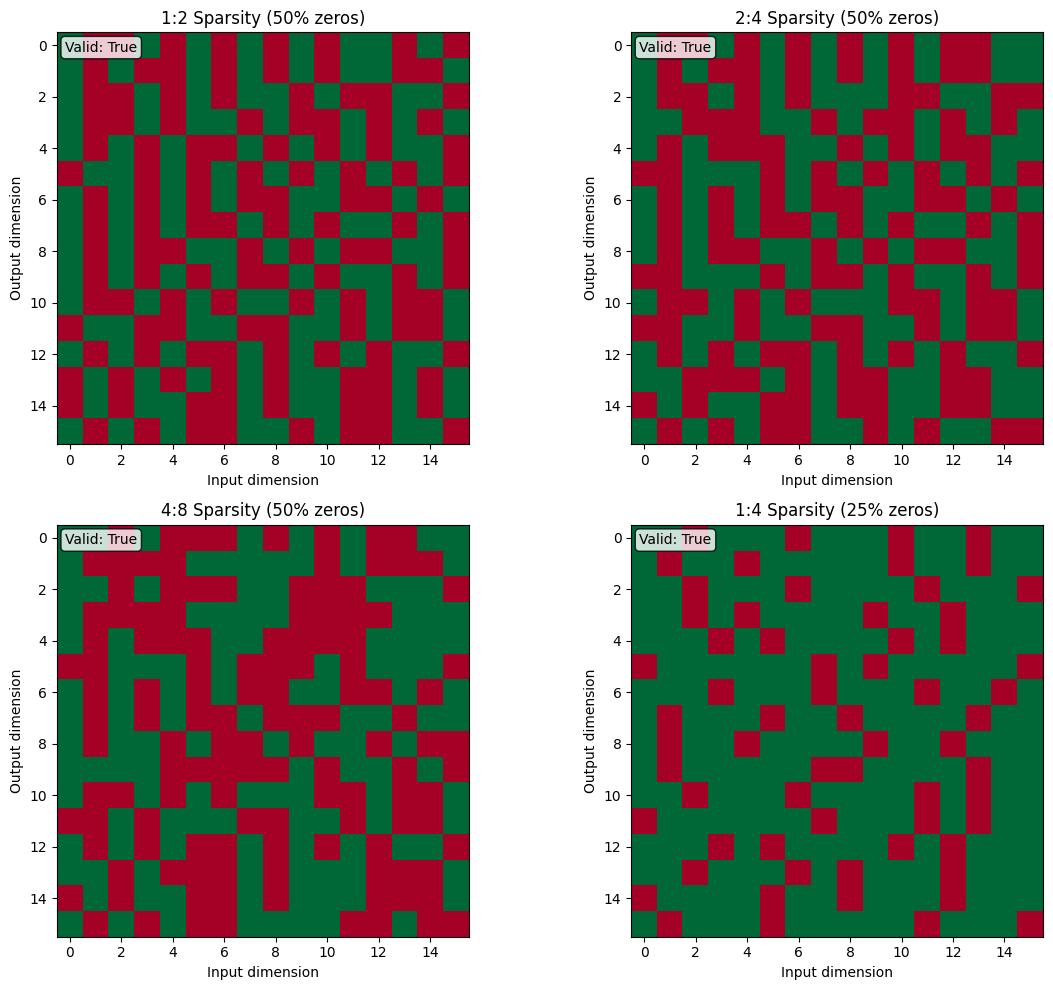

In [26]:
# Visualize N:M sparsity pattern

def visualize_nm_pattern():
    """Visualize different N:M sparsity patterns."""
    patterns = [(1, 2), (2, 4), (4, 8), (1, 4)]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Create sample weight
    torch.manual_seed(42)
    weight = torch.randn(16, 16)

    for ax, (n, m) in zip(axes, patterns):
        nm = NMSparsity(n, m)
        mask = nm.create_mask(weight)
        masked_weight = weight * mask

        # Show mask pattern
        im = ax.imshow(mask.numpy(), cmap='RdYlGn', vmin=0, vmax=1)
        ax.set_title(f'{n}:{m} Sparsity ({100*n/m:.0f}% zeros)')
        ax.set_xlabel('Input dimension')
        ax.set_ylabel('Output dimension')

        # Verify pattern
        valid = nm.verify_pattern(masked_weight)
        ax.text(0.02, 0.98, f'Valid: {valid}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('nm_sparsity_patterns.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_nm_pattern()

terative Magnitude Pruning (IMP)

IMP is the standard method for finding lottery tickets. It repeatedly trains, prunes, and rewinds to initial weights.

In [27]:
class IterativeMagnitudePruning:


    def __init__(
        self,
        model: PrunableMLP,
        pruning_rate: float = 0.2,
        num_iterations: int = 5
    ):
        """
        Args:
            model: Model to prune
            pruning_rate: Fraction to prune in each iteration
            num_iterations: Number of prune-train cycles
        """
        self.model = model
        self.pruning_rate = pruning_rate
        self.num_iterations = num_iterations

        # Store initial weights
        self.initial_weights: Dict[str, torch.Tensor] = {}
        self._store_initial_weights()

        # Current masks (start with all ones)
        self.masks: Dict[str, torch.Tensor] = {}
        self._init_masks()

    def _store_initial_weights(self):
        """Store initial weights for rewinding."""
        for i, layer in enumerate(self.model.layers):
            self.initial_weights[f'layer_{i}'] = layer.weight.data.clone()
        self.initial_weights['output'] = self.model.output.weight.data.clone()

    def _init_masks(self):
        """Initialize masks to all ones."""
        for i, layer in enumerate(self.model.layers):
            self.masks[f'layer_{i}'] = torch.ones_like(layer.weight.data)
        self.masks['output'] = torch.ones_like(self.model.output.weight.data)

    def prune_once(self, global_pruning: bool = True):
        """
        Perform one pruning step based on magnitude.

        Prunes `pruning_rate` fraction of currently unpruned weights.
        """
        if global_pruning:
            # Collect all unpruned weights
            all_weights = []
            weight_indices = []  # Track which layer each weight belongs to

            for key in self.masks:
                if key.startswith('layer_'):
                    idx = int(key.split('_')[1])
                    weight = self.model.layers[idx].weight.data
                else:
                    weight = self.model.output.weight.data

                mask = self.masks[key]
                unpruned = weight[mask == 1]
                all_weights.append(unpruned.abs().flatten())

            all_weights = torch.cat(all_weights)

            # Find threshold
            k = int(len(all_weights) * self.pruning_rate)
            if k == 0:
                return
            threshold = torch.kthvalue(all_weights, k)[0]

            # Update masks
            for key in self.masks:
                if key.startswith('layer_'):
                    idx = int(key.split('_')[1])
                    weight = self.model.layers[idx].weight.data
                else:
                    weight = self.model.output.weight.data

                # Only prune currently unpruned weights below threshold
                new_prune = (weight.abs() < threshold) & (self.masks[key] == 1)
                self.masks[key][new_prune] = 0
        else:
            # Per-layer pruning
            for key in self.masks:
                if key.startswith('layer_'):
                    idx = int(key.split('_')[1])
                    weight = self.model.layers[idx].weight.data
                else:
                    weight = self.model.output.weight.data

                mask = self.masks[key]
                unpruned = weight[mask == 1].abs()

                if len(unpruned) == 0:
                    continue

                k = max(1, int(len(unpruned) * self.pruning_rate))
                threshold = torch.kthvalue(unpruned.flatten(), k)[0]

                new_prune = (weight.abs() < threshold) & (mask == 1)
                self.masks[key][new_prune] = 0

    def rewind_weights(self):
        """
        Rewind weights to initial values (keep current mask).
        """
        for i, layer in enumerate(self.model.layers):
            layer.weight.data = self.initial_weights[f'layer_{i}'].clone()
        self.model.output.weight.data = self.initial_weights['output'].clone()

    def apply_masks(self):
        """Apply current masks to model."""
        for i, layer in enumerate(self.model.layers):
            self.model.set_mask(i, self.masks[f'layer_{i}'])
        self.model.set_mask(len(self.model.layers), self.masks['output'])
        self.model.apply_masks()

    def get_sparsity(self) -> float:
        """Get overall sparsity."""
        total_zeros = sum((m == 0).sum().item() for m in self.masks.values())
        total_params = sum(m.numel() for m in self.masks.values())
        return total_zeros / total_params

    def run(
        self,
        train_loader: DataLoader,
        test_loader: DataLoader,
        epochs_per_iteration: int = 3,
        lr: float = 0.001
    ) -> Dict[str, List]:
        """
        Run full IMP procedure.

        Returns:
            History of sparsity and accuracy at each iteration
        """
        history = {
            'iteration': [],
            'sparsity': [],
            'accuracy': []
        }

        for iteration in range(self.num_iterations):
            print(f"\nIMP Iteration {iteration + 1}/{self.num_iterations}")

            # Rewind to initial weights
            if iteration > 0:
                self.rewind_weights()

            # Apply current mask
            self.apply_masks()

            # Train
            optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
            for epoch in range(epochs_per_iteration):
                train_epoch(self.model, train_loader, optimizer,
                           apply_mask_fn=self.apply_masks)

            # Evaluate
            accuracy = evaluate(self.model, test_loader)
            sparsity = self.get_sparsity()

            history['iteration'].append(iteration + 1)
            history['sparsity'].append(sparsity)
            history['accuracy'].append(accuracy)

            print(f"  Sparsity: {100*sparsity:.1f}%, Accuracy: {100*accuracy:.2f}%")

            # Prune for next iteration (skip on last)
            if iteration < self.num_iterations - 1:
                self.prune_once(global_pruning=True)

        return history

Experimental Comparisons

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("=" * 70)
print("TRAINING BASELINE MODEL")
print("=" * 70)

baseline_model = PrunableMLP().to(device)
baseline_model = train_model(baseline_model, train_loader, epochs=5)
baseline_acc = evaluate(baseline_model, test_loader)
print(f"\nBaseline Accuracy: {100*baseline_acc:.2f}%")

# Save initial state (before training)
torch.manual_seed(42)
init_model = PrunableMLP().to(device)
initial_state = deepcopy(init_model.state_dict())

# Save trained state
trained_state = deepcopy(baseline_model.state_dict())

TRAINING BASELINE MODEL
Epoch 1: Train Acc=93.53%, Test Acc=95.29%
Epoch 2: Train Acc=97.31%, Test Acc=97.11%
Epoch 3: Train Acc=98.13%, Test Acc=97.50%
Epoch 4: Train Acc=98.61%, Test Acc=97.63%
Epoch 5: Train Acc=98.72%, Test Acc=97.00%

Baseline Accuracy: 97.00%


In [29]:
# Experiment 1: Movement Pruning

print("\n" + "=" * 70)
print("EXPERIMENT 1: Movement Pruning")
print("=" * 70)

target_sparsities = [0.5, 0.7, 0.9]
movement_results = {}

for target in target_sparsities:
    print(f"\nTarget sparsity: {100*target:.0f}%")

    # Fresh model
    model = PrunableMLP().to(device)
    model.load_state_dict(deepcopy(initial_state))

    # Movement pruner
    pruner = MovementPruner(model, target_sparsity=target)

    # Train while tracking movement
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(5):
        model.train()
        for data, target_label in train_loader:
            data, target_label = data.to(device), target_label.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target_label)
            loss.backward()

            # Update movement scores before optimizer step
            pruner.update_movement_scores(use_gradient=True)

            optimizer.step()

    # Compute and apply masks
    masks = pruner.compute_masks(global_pruning=True)
    pruner.apply_masks(masks)

    # Fine-tune
    print("  Fine-tuning...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(3):
        train_epoch(model, train_loader, optimizer, apply_mask_fn=model.apply_masks)

    accuracy = evaluate(model, test_loader)
    actual_sparsity = model.get_sparsity()['overall']

    movement_results[target] = {
        'accuracy': accuracy,
        'sparsity': actual_sparsity
    }

    print(f"  Final: {100*actual_sparsity:.1f}% sparse, {100*accuracy:.2f}% acc")


EXPERIMENT 1: Movement Pruning

Target sparsity: 50%
  Fine-tuning...
  Final: 50.0% sparse, 93.41% acc

Target sparsity: 70%
  Fine-tuning...
  Final: 70.0% sparse, 92.81% acc

Target sparsity: 90%
  Fine-tuning...
  Final: 90.0% sparse, 89.04% acc


In [30]:
# Experiment 2: Learned Sparsity

print("\n" + "=" * 70)
print("EXPERIMENT 2: Learned Sparsity")
print("=" * 70)

learned_results = {}

for target in [0.5, 0.7, 0.9]:
    print(f"\nTarget sparsity: {100*target:.0f}%")

    model = LearnedSparsityMLP().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train with sparsity loss
    for epoch in range(5):
        model.train()
        total_loss = 0

        for data, target_label in train_loader:
            data, target_label = data.to(device), target_label.to(device)

            optimizer.zero_grad()
            output = model(data)

            # Task loss + sparsity loss
            task_loss = F.cross_entropy(output, target_label)
            sparse_loss = model.sparsity_loss(target_sparsity=target, lambda_sparse=1.0)
            loss = task_loss + sparse_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        sparsity_stats = model.get_sparsity()
        test_acc = evaluate(model, test_loader)
        print(f"  Epoch {epoch+1}: {100*sparsity_stats['overall']:.1f}% sparse, {100*test_acc:.2f}% acc")

    final_sparsity = model.get_sparsity()['overall']
    final_acc = evaluate(model, test_loader)

    learned_results[target] = {
        'accuracy': final_acc,
        'sparsity': final_sparsity
    }


EXPERIMENT 2: Learned Sparsity

Target sparsity: 50%
  Epoch 1: 0.0% sparse, 95.97% acc
  Epoch 2: 0.0% sparse, 97.36% acc
  Epoch 3: 0.0% sparse, 97.24% acc
  Epoch 4: 0.0% sparse, 97.81% acc
  Epoch 5: 0.0% sparse, 97.88% acc

Target sparsity: 70%
  Epoch 1: 0.0% sparse, 96.27% acc
  Epoch 2: 0.0% sparse, 96.98% acc
  Epoch 3: 0.0% sparse, 96.44% acc
  Epoch 4: 0.0% sparse, 97.32% acc
  Epoch 5: 0.0% sparse, 97.27% acc

Target sparsity: 90%
  Epoch 1: 0.0% sparse, 96.63% acc
  Epoch 2: 0.0% sparse, 96.97% acc
  Epoch 3: 0.0% sparse, 97.66% acc
  Epoch 4: 0.0% sparse, 97.37% acc
  Epoch 5: 0.0% sparse, 97.39% acc


In [31]:
# Experiment 3: N:M Structured Sparsity

print("\n" + "=" * 70)
print("EXPERIMENT 3: N:M Structured Sparsity")
print("=" * 70)

nm_patterns = [(1, 2), (2, 4), (1, 4)]
nm_results = {}

for n, m in nm_patterns:
    print(f"\n{n}:{m} Sparsity ({100*n/m:.0f}% zeros)")

    # Fresh model
    model = PrunableMLP().to(device)
    model.load_state_dict(deepcopy(initial_state))

    # N:M trainer
    trainer = NMSparsityTrainer(model, n=n, m=m)
    trainer.initialize_masks()

    # Train with N:M constraints
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(5):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            trainer.train_step(data, target, optimizer)

        # Update masks periodically
        if epoch % 2 == 0:
            trainer.update_masks()

        test_acc = evaluate(model, test_loader)
        print(f"  Epoch {epoch+1}: {100*test_acc:.2f}%")

    final_acc = evaluate(model, test_loader)
    nm_results[(n, m)] = {
        'accuracy': final_acc,
        'sparsity': n / m
    }


EXPERIMENT 3: N:M Structured Sparsity

1:2 Sparsity (50% zeros)
  Epoch 1: 96.73%
  Epoch 2: 97.45%
  Epoch 3: 97.16%
  Epoch 4: 96.85%
  Epoch 5: 97.89%

2:4 Sparsity (50% zeros)
  Epoch 1: 96.52%
  Epoch 2: 97.09%
  Epoch 3: 97.72%
  Epoch 4: 97.65%
  Epoch 5: 97.42%

1:4 Sparsity (25% zeros)
  Epoch 1: 96.85%
  Epoch 2: 96.50%
  Epoch 3: 97.72%
  Epoch 4: 97.88%
  Epoch 5: 97.39%


In [32]:
# Experiment 4: Iterative Magnitude Pruning

print("\n" + "=" * 70)
print("EXPERIMENT 4: Iterative Magnitude Pruning (IMP)")
print("=" * 70)

model = PrunableMLP().to(device)
model.load_state_dict(deepcopy(initial_state))

imp = IterativeMagnitudePruning(
    model,
    pruning_rate=0.2,  # Prune 20% each iteration
    num_iterations=6   # ~74% final sparsity
)

imp_history = imp.run(
    train_loader,
    test_loader,
    epochs_per_iteration=3,
    lr=0.001
)


EXPERIMENT 4: Iterative Magnitude Pruning (IMP)

IMP Iteration 1/6
  Sparsity: 0.0%, Accuracy: 97.53%

IMP Iteration 2/6
  Sparsity: 20.0%, Accuracy: 97.95%

IMP Iteration 3/6
  Sparsity: 36.0%, Accuracy: 97.67%

IMP Iteration 4/6
  Sparsity: 48.8%, Accuracy: 97.05%

IMP Iteration 5/6
  Sparsity: 59.0%, Accuracy: 97.93%

IMP Iteration 6/6
  Sparsity: 67.2%, Accuracy: 98.13%


In [33]:
# Experiment 5: Compare all methods at similar sparsity

print("\n" + "=" * 70)
print("EXPERIMENT 5: Method Comparison at ~50% Sparsity")
print("=" * 70)

# Magnitude pruning baseline
def magnitude_prune(model_state, sparsity):
    model = PrunableMLP().to(device)
    model.load_state_dict(deepcopy(model_state))

    # Collect all weights
    all_weights = []
    for i, layer in enumerate(model.layers):
        all_weights.append(layer.weight.data.abs().flatten())
    all_weights.append(model.output.weight.data.abs().flatten())
    all_weights = torch.cat(all_weights)

    # Find threshold
    k = int(len(all_weights) * sparsity)
    threshold = torch.kthvalue(all_weights, k)[0]

    # Apply masks
    for i, layer in enumerate(model.layers):
        mask = (layer.weight.data.abs() >= threshold).float()
        model.set_mask(i, mask)

    mask = (model.output.weight.data.abs() >= threshold).float()
    model.set_mask(len(model.layers), mask)
    model.apply_masks()

    return model


# Compare at 50% sparsity
comparison_results = {}

# 1. Magnitude pruning (no fine-tune)
model = magnitude_prune(trained_state, 0.5)
comparison_results['Magnitude (no FT)'] = evaluate(model, test_loader)

# 2. Magnitude pruning (with fine-tune)
model = magnitude_prune(trained_state, 0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
for _ in range(3):
    train_epoch(model, train_loader, optimizer, apply_mask_fn=model.apply_masks)
comparison_results['Magnitude (FT)'] = evaluate(model, test_loader)

# 3. Movement pruning
comparison_results['Movement'] = movement_results[0.5]['accuracy']

# 4. Learned sparsity
comparison_results['Learned'] = learned_results[0.5]['accuracy']

# 5. N:M (2:4 = 50%)
comparison_results['N:M (2:4)'] = nm_results[(2, 4)]['accuracy']

print("\nResults at ~50% sparsity:")
print(f"  Baseline (dense): {100*baseline_acc:.2f}%")
for method, acc in comparison_results.items():
    print(f"  {method}: {100*acc:.2f}%")


EXPERIMENT 5: Method Comparison at ~50% Sparsity

Results at ~50% sparsity:
  Baseline (dense): 97.00%
  Magnitude (no FT): 96.84%
  Magnitude (FT): 98.51%
  Movement: 93.41%
  Learned: 97.88%
  N:M (2:4): 97.42%


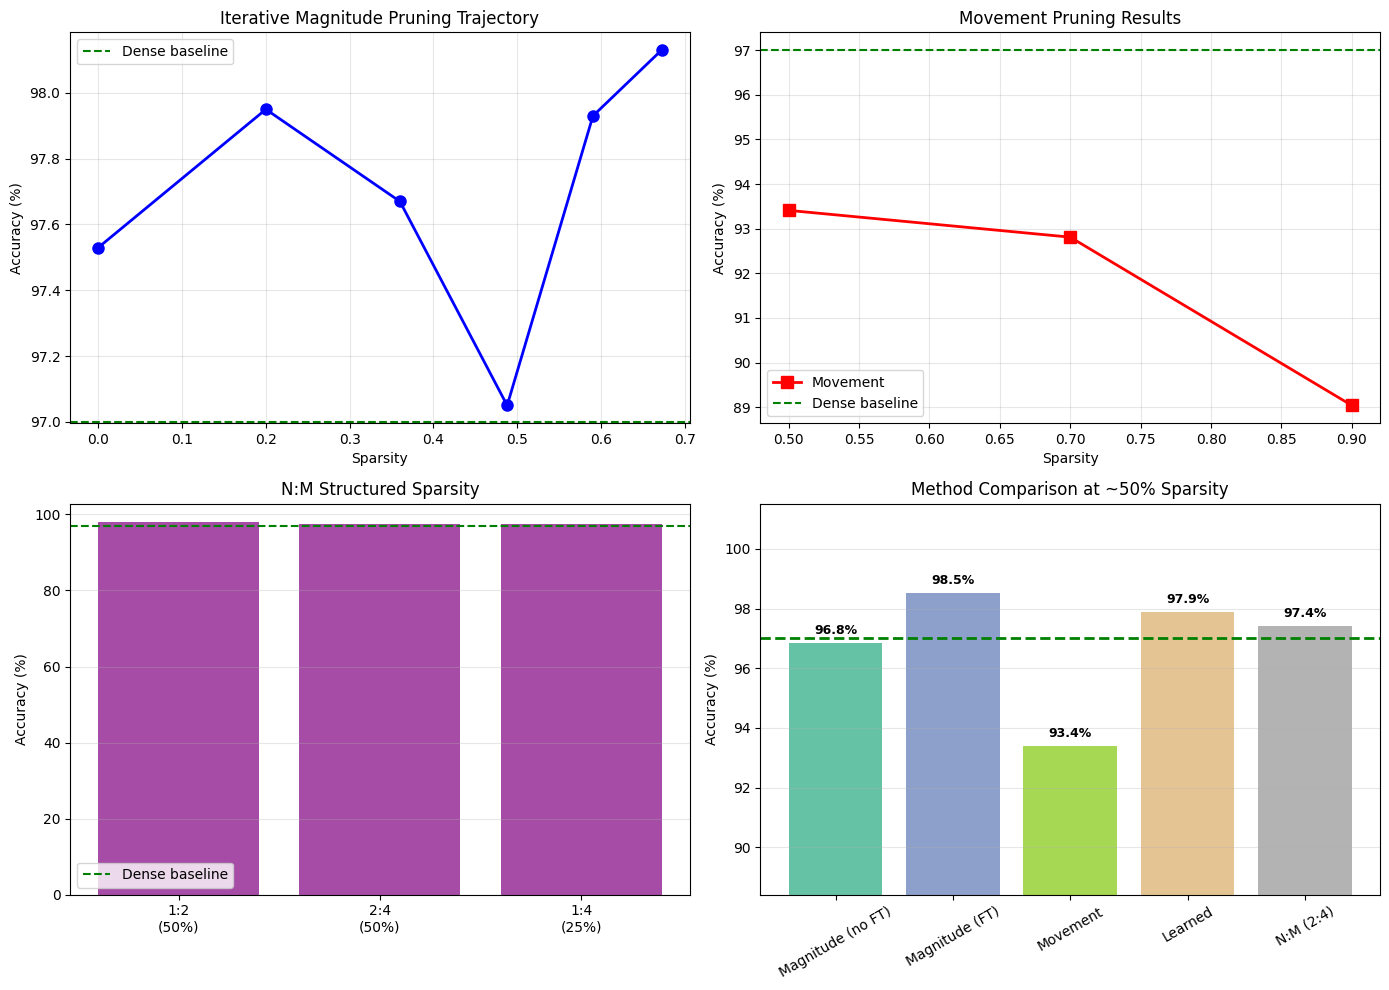

In [34]:
# Comprehensive visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: IMP trajectory
ax = axes[0, 0]
ax.plot(imp_history['sparsity'], [a*100 for a in imp_history['accuracy']], 'o-',
        linewidth=2, markersize=8, color='blue')
ax.axhline(y=baseline_acc*100, color='green', linestyle='--', label='Dense baseline')
ax.set_xlabel('Sparsity')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Iterative Magnitude Pruning Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Movement pruning results
ax = axes[0, 1]
sparsities = [movement_results[t]['sparsity'] for t in target_sparsities]
accuracies = [movement_results[t]['accuracy']*100 for t in target_sparsities]
ax.plot(sparsities, accuracies, 's-', linewidth=2, markersize=8, color='red', label='Movement')
ax.axhline(y=baseline_acc*100, color='green', linestyle='--', label='Dense baseline')
ax.set_xlabel('Sparsity')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Movement Pruning Results')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: N:M comparison
ax = axes[1, 0]
patterns = list(nm_results.keys())
nm_accs = [nm_results[p]['accuracy']*100 for p in patterns]
nm_sparsities = [nm_results[p]['sparsity'] for p in patterns]

x = np.arange(len(patterns))
bars = ax.bar(x, nm_accs, color='purple', alpha=0.7)
ax.axhline(y=baseline_acc*100, color='green', linestyle='--', label='Dense baseline')
ax.set_xticks(x)
ax.set_xticklabels([f'{n}:{m}\n({100*n/m:.0f}%)' for n, m in patterns])
ax.set_ylabel('Accuracy (%)')
ax.set_title('N:M Structured Sparsity')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Method comparison at 50% sparsity
ax = axes[1, 1]
methods = list(comparison_results.keys())
accs = [comparison_results[m]*100 for m in methods]
colors = plt.cm.Set2(np.linspace(0, 1, len(methods)))

bars = ax.bar(methods, accs, color=colors)
ax.axhline(y=baseline_acc*100, color='green', linestyle='--', linewidth=2)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Method Comparison at ~50% Sparsity')
ax.set_ylim(min(accs) - 5, max(accs) + 3)
ax.tick_params(axis='x', rotation=30)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{acc:.1f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('advanced_pruning_results.png', dpi=150, bbox_inches='tight')
plt.show()